In [1]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch, random, string
from torchtext import data , datasets
from collections import defaultdict, Counter
import numpy as np

os.environ['GENSIM_DATA_DIR'] = os.path.join(os.getcwd(), 'gensim-data')

import gensim.downloader as api
from gensim.models.fasttext import load_facebook_model

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from utils import data_prep

In [2]:
SEED = 42
train_data, validation_data, test_data, LABEL, TEXT = data_prep(SEED)


{'text': ['How', 'tall', 'is', 'Prince', 'Charles', '?'], 'label': 'NUM'}

Label distribution in training set:
- ABBR: 69 samples (1.58%)
- DESC: 930 samples (21.32%)
- ENTY: 1000 samples (22.93%)
- HUM: 978 samples (22.42%)
- LOC: 668 samples (15.31%)
- NUM: 717 samples (16.44%)
Total samples: 4362, Sum of percentages: 100.00%


In [3]:
for ex in train_data:
    print(f'{ex.label}: {ex.text}')

NUM: ['How', 'tall', 'is', 'Prince', 'Charles', '?']
NUM: ['What', 'does', 'an', 'average', 'daycare', 'provider', 'get', 'paid', 'in', 'New', 'England', '?']
NUM: ['What', 'are', 'the', 'three', 'winter', 'months', 'in', 'the', 'southern', 'hemisphere', '?']
NUM: ['How', 'many', 'events', 'make', 'up', 'the', 'decathlon', '?']
NUM: ['How', 'many', 'years', 'ago', 'did', 'Led', 'Zeppelin', 'release', 'its', 'last', 'album', '?']
NUM: ['How', 'long', 'did', 'it', 'take', 'Stanley', 'to', 'find', 'Livingstone', '?']
NUM: ['How', 'fast', 'is', 'a', '45Mhz', 'processor', '?']
NUM: ['How', 'many', 'Gutenberg', 'Bibles', 'are', 'there', '?']
NUM: ['How', 'many', 'flavors', 'of', 'ice', 'cream', 'does', 'Howard', 'Johnson', "'s", 'have', '?']
NUM: ['How', 'far', 'do', 'you', 'have', 'to', 'run', 'if', 'you', 'hit', 'a', 'home', 'run', '?']
NUM: ['How', 'many', 'countries', 'watch', 'MTV', 'Europe', '?']
NUM: ['How', 'much', 'did', 'Alaska', 'cost', 'when', 'bought', 'from', 'Russia', '?']
NUM

In [4]:
#### a) Size of Vocabulary formed from training data according to tokenization method
# Vocabulary size (includes specials like <unk>, <pad>)
TEXT.build_vocab(train_data, min_freq=1)
vocab_size = len(TEXT.vocab)
print("Vocabulary Size (with specials):", vocab_size)

vocab_wo_specials = len([w for w in TEXT.vocab.stoi if w not in {TEXT.unk_token, TEXT.pad_token}])
print("Vocabulary size (no specials):", vocab_wo_specials)

Vocabulary Size (with specials): 8148
Vocabulary size (no specials): 8146


In [5]:
#### b) How many OOV words exist in your training data?
####    What is the number of OOV words for each topic category?
# Load Word2Vec model from local file instead of downloading
w2v = api.load('word2vec-google-news-300')
# w2v = KeyedVectors.load('word2vec-google-news-300.model')
w2v_vocab = w2v.key_to_index

# Get training vocab tokens (types), excluding specials
specials = {TEXT.unk_token, TEXT.pad_token}
train_vocab_types = [w for w in TEXT.vocab.stoi.keys() if w not in specials]

# Overall OOV types in training vocab
oov_types_overall = {w for w in train_vocab_types if w not in w2v_vocab}
print("Number of OOV word types (overall):", len(oov_types_overall))

# OOV types per label (unique types per category across its sentences)
label_to_oov_types = defaultdict(set)
label_to_total_types = defaultdict(set)

for ex in train_data.examples:
    label = ex.label
    # Count by unique types per sentence to avoid overcounting repeats
    for w in set(ex.text):
        label_to_total_types[label].add(w)
        if w not in specials and w not in w2v_vocab:
            label_to_oov_types[label].add(w)

print("\nOOV word types per topic label:")
for label in sorted(label_to_total_types.keys()):
    num_oov = len(label_to_oov_types[label])
    num_types = len(label_to_total_types[label])
    rate = (num_oov / num_types) if num_types > 0 else 0.0
    print(f"- {label}: {num_oov} OOV types (out of {num_types}, rate={rate:.2%})")

Number of OOV word types (overall): 425

OOV word types per topic label:
- ABBR: 20 OOV types (out of 148, rate=13.51%)
- DESC: 122 OOV types (out of 2263, rate=5.39%)
- ENTY: 149 OOV types (out of 2987, rate=4.99%)
- HUM: 137 OOV types (out of 3070, rate=4.46%)
- LOC: 83 OOV types (out of 1760, rate=4.72%)
- NUM: 83 OOV types (out of 1898, rate=4.37%)


In [6]:
# #### c) OOV mitigation strategy (No transformer-based language models allowed)
# Implement your solution in your source code. Show the corresponding code snippet.
# 1. Fast Text Model Implementatation
# Load FastText with subword info (pretrained on Wikipedia)
# First download is large; cached afterwards

# 2. Modelling Unknown (<UNK>) token approach
# Make the <unk> vector informative and trainable by initializing it
# as the mean of available pretrained vectors.

# Loading fasttext model
fatter_fasttext_bin = load_facebook_model('crawl-300d-2M-subword/crawl-300d-2M-subword.bin')
embedding_dim = fatter_fasttext_bin.wv.vector_size

# Build embedding matrix aligned to TEXT.vocab
num_tokens = len(TEXT.vocab)
emb_matrix = np.zeros((num_tokens, embedding_dim), dtype=np.float32)

# torchtext 0.4.0: TEXT.vocab.itos is index->token, stoi is token->index
pad_tok = TEXT.pad_token
unk_tok = TEXT.unk_token

# Getting index of <unk> in vocab
unk_index = TEXT.vocab.stoi[TEXT.unk_token]
known_vecs = []

for idx, token in enumerate(TEXT.vocab.itos):
    # Skip specials here; we will set them explicitly below
    if token in {pad_tok, unk_tok}:
        continue

    vec = fatter_fasttext_bin.wv[token]
    emb_matrix[idx] = vec
    known_vecs.append(vec)

if len(known_vecs) > 0:
    unk_mean = torch.tensor(np.mean(known_vecs, axis=0), dtype=torch.float32)
else:
    unk_mean = torch.empty(embedding_dim).uniform_(-0.05, 0.05)
with torch.no_grad():
    emb_matrix[unk_index] = unk_mean

# Create Embedding layer initialized with FastText
fatter_embedding = torch.nn.Embedding(num_tokens, embedding_dim, padding_idx=TEXT.vocab.stoi[TEXT.pad_token])
fatter_embedding.weight.data.copy_(torch.from_numpy(emb_matrix))

torch.save(fatter_embedding, 'weights/embedding_weights_fatter_fasttext.pt')

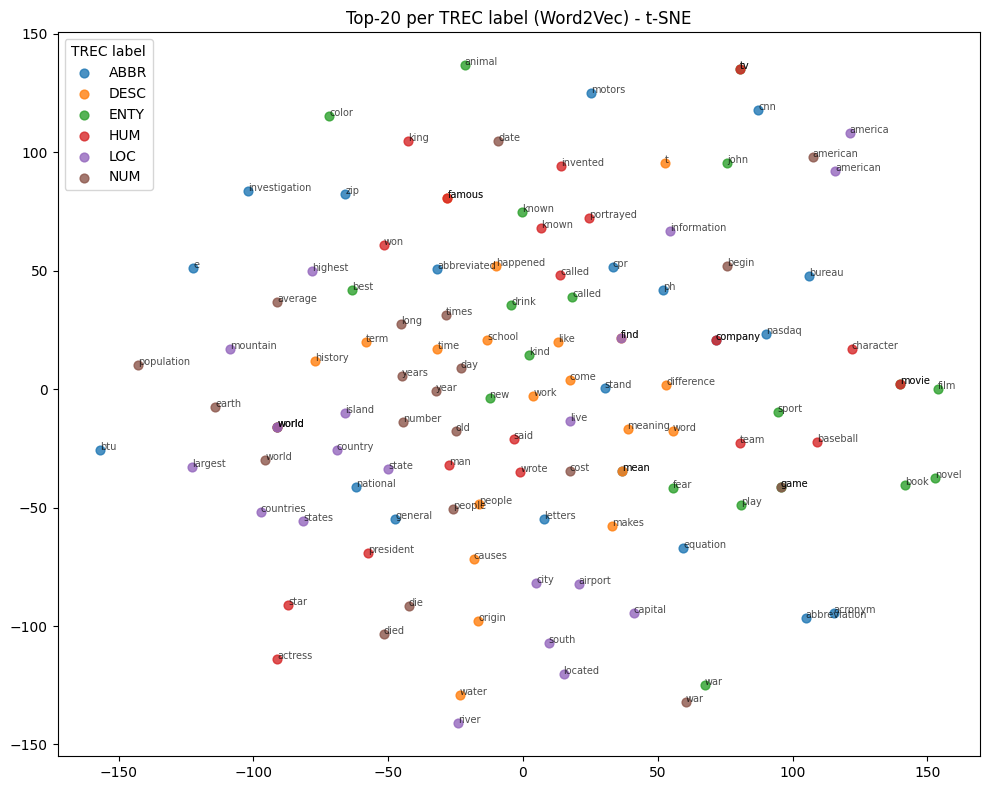

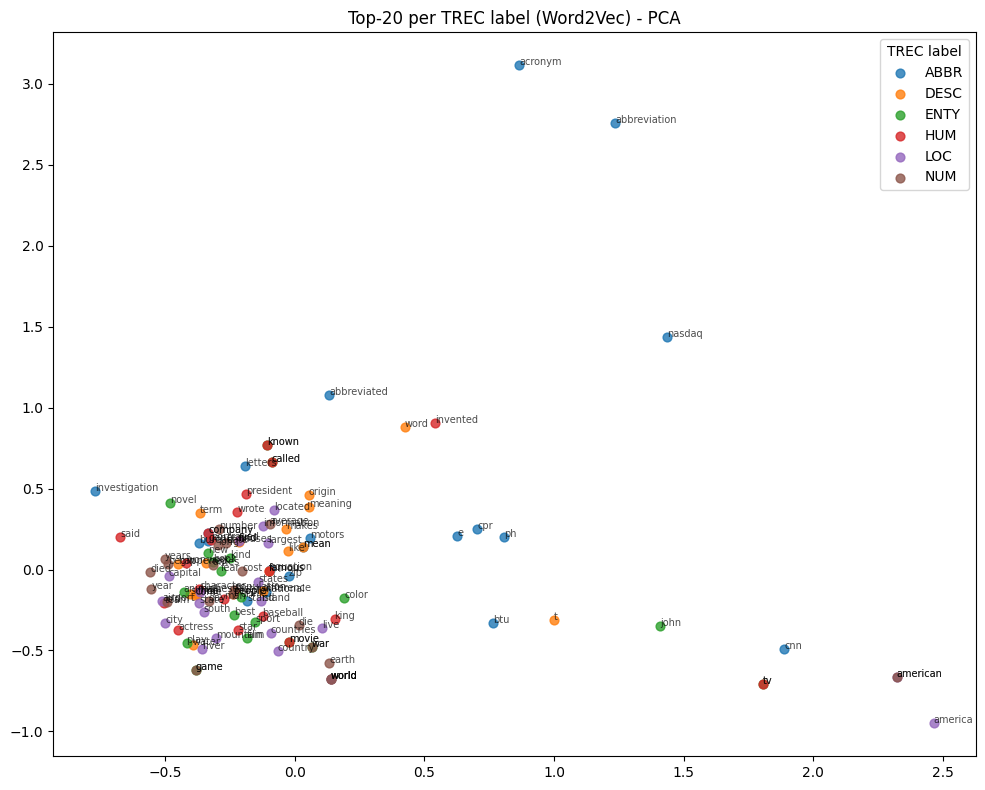

Saved plots: trec_top20_tsne.png, trec_top20_pca.png
ABBR: ['stand', 'abbreviation', 'mean', 'national', 'bureau', 'investigation', 'acronym', 'abbreviated', 'e', 'letters', 'zip', 'cnn', 'equation', 'cpr', 'ph', 'btu', 'nasdaq', 'company', 'general', 'motors']
DESC: ['mean', 'origin', 'word', 'difference', 'find', 'meaning', 'come', 'work', 'people', 'term', 'causes', 'school', 't', 'makes', 'happened', 'like', 'history', 'time', 'famous', 'water']
ENTY: ['fear', 'kind', 'called', 'film', 'world', 'color', 'best', 'book', 'movie', 'drink', 'novel', 'war', 'tv', 'sport', 'animal', 'play', 'known', 'game', 'john', 'new']
HUM: ['president', 'company', 'wrote', 'world', 'famous', 'tv', 'won', 'invented', 'movie', 'team', 'character', 'said', 'baseball', 'known', 'man', 'portrayed', 'actress', 'star', 'king', 'called']
LOC: ['country', 'city', 'state', 'world', 'find', 'largest', 'capital', 'highest', 'river', 'located', 'live', 'countries', 'states', 'information', 'mountain', 'island', '

In [7]:
#### d) Select the 20 most frequent words from each topic category in the training set (removing
# stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe).
# Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis).
# Plot the points in a scatter plot, color-coded by their topic category. Attach your plot here.
# Analyze your findings.

# Build per-label token frequency (lowercased, stopwords/punct filtered)
label_to_counter = defaultdict(Counter)
valid_chars = set(string.ascii_letters)

def is_valid_token(tok: str) -> bool:
    t = tok.strip("'\"")
    if len(t) == 0:
        return False
    # Keep purely alphabetic tokens to avoid punctuation/numbers
    return t.isalpha()

for ex in train_data.examples:
    label = ex.label
    for tok in ex.text:
        tok_l = tok.lower()
        if tok_l in STOP_WORDS:
            continue
        if not is_valid_token(tok_l):
            continue
        label_to_counter[label][tok_l] += 1

# Select top 20 per label that exist in Word2Vec
topk = 20
label_to_top_tokens = {}
for label, ctr in label_to_counter.items():
    selected = []
    for tok, _ in ctr.most_common():
        if tok in w2v.key_to_index:
            selected.append(tok)
        if len(selected) >= topk:
            break
    label_to_top_tokens[label] = selected

# Collect embeddings and labels
points = []
point_labels = []
point_words = []
for label, toks in label_to_top_tokens.items():
    for tok in toks:
        vec = w2v.get_vector(tok)
        points.append(vec)
        point_labels.append(label)
        point_words.append(tok)

if len(points) > 0:
    X = np.vstack(points)

    # 2D projections
    # tsne_2d = TSNE(n_components=2, random_state=42, init="pca", perplexity=30).fit_transform(X)
    # pca_2d = PCA(n_components=2, random_state=42).fit_transform(X)
    tsne_2d = TSNE(n_components=2, random_state=SEED, init="pca", perplexity=30).fit_transform(X)
    pca_2d = PCA(n_components=2, random_state=SEED).fit_transform(X)

    # Assign colors per label
    unique_labels = sorted(set(point_labels))
    color_map = {lab: plt.cm.tab10(i % 10) for i, lab in enumerate(unique_labels)}

    def plot_scatter(Y2, title: str, fname: str):
        plt.figure(figsize=(10, 8))
        for lab in unique_labels:
            idxs = [i for i, l in enumerate(point_labels) if l == lab]
            plt.scatter(Y2[idxs, 0], Y2[idxs, 1], c=[color_map[lab]], label=lab, alpha=0.8, s=40)
            # Light word annotations (optional; can clutter)
            for i in idxs:
                plt.annotate(point_words[i], (Y2[i, 0], Y2[i, 1]), fontsize=7, alpha=0.7)
        plt.legend(title="TREC label")
        plt.title(title)
        plt.tight_layout()
        plt.show()
        plt.savefig(fname, dpi=200)
        plt.close()

    plot_scatter(tsne_2d, "Top-20 per TREC label (Word2Vec) - t-SNE", "trec_top20_tsne.png")
    plot_scatter(pca_2d, "Top-20 per TREC label (Word2Vec) - PCA", "trec_top20_pca.png")

    print("Saved plots: trec_top20_tsne.png, trec_top20_pca.png")
    for lab in unique_labels:
        print(f"{lab}: {label_to_top_tokens[lab]}")
else:
    print("No points collected for visualization. Check filtering or embedding availability.")